In [116]:
import torch
import torchvision
from torchvision import models, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
device =  torch.device('cuda')

In [117]:
class_name = {
    0: 'down',
    1: 'middle',
    2: 'up'
}
DOWN = 0
MIDDLE = 1
UP = 2

We will start out with a vgg16 network like we did in hw5. I will later try resnet, and compare results. But first, lets load in the pretrained model.

In [133]:
vgg16 = models.vgg16(pretrained=True).to(device)
#print(vgg16.modules)

We will also freeze all the layers except the classification layer, so we can train the model on our data. 

In [134]:
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier._modules['6'] = nn.Linear(4096, 3)

In [135]:
transform = transforms.Compose([
    transforms.Resize((180, 320)),  
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='./data/validation', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=16,
                                          shuffle=True)


In [128]:
def get_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader: 
            images, labels = data[0].to(device), data[1].to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [136]:
# Used first source from bibliography to help set this up, however, I did not copy and paste. I had already made it,
# but I updated it to have features like time and base it off accuracy instead of loss.
def train(model, epochs, path):
    model.cuda()
    start = time.time()
    best_acc = 0.0
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    running_loss = 0
    for j in range(epochs):
        print('Epoch {}/{}'.format(j, epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                model.train()
                for i, data in enumerate(trainloader):
                    inputs, labels = data[0].to(device), data[1].to(device) # get mini batch data
                    optimizer.zero_grad() 
                    outputs = model(inputs) 
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicted == labels.data)
                epoch_loss = running_loss / len(trainloader.dataset)
                epoch_acc = running_corrects.double() / len(trainloader.dataset)

            else:
                model.eval()
                for i, data in enumerate(valloader):
                    inputs, labels = data[0].to(device), data[1].to(device) # get mini batch data
                    optimizer.zero_grad()
                    with torch.no_grad():
                        outputs = model(inputs) 
                        loss = criterion(outputs, labels)
                        _, predicted = torch.max(outputs.data, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicted == labels.data)
                epoch_loss = running_loss / len(valloader.dataset)
                epoch_acc = running_corrects.double() / len(valloader.dataset)

        
            print('{} Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc * 100))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), path)
                
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc * 100))
    model.load_state_dict(torch.load(path))

In [137]:
train(vgg16, epochs=10, path='vgg16.pth')

Epoch 0/9
----------
train Loss: 1.0738 Acc: 42.5901
val Loss: 0.9116 Acc: 69.6809
Epoch 1/9
----------
train Loss: 0.9137 Acc: 57.5434
val Loss: 0.7871 Acc: 77.1277
Epoch 2/9
----------
train Loss: 0.7973 Acc: 66.0881
val Loss: 0.6972 Acc: 84.5745
Epoch 3/9
----------
train Loss: 0.7242 Acc: 73.2977
val Loss: 0.6408 Acc: 86.7021
Epoch 4/9
----------
train Loss: 0.6930 Acc: 73.5648
val Loss: 0.5984 Acc: 87.7660
Epoch 5/9
----------
train Loss: 0.6567 Acc: 74.4993
val Loss: 0.5573 Acc: 88.8298
Epoch 6/9
----------
train Loss: 0.6066 Acc: 79.1722
val Loss: 0.5345 Acc: 87.2340
Epoch 7/9
----------
train Loss: 0.6006 Acc: 75.9680
val Loss: 0.5067 Acc: 92.0213
Epoch 8/9
----------
train Loss: 0.5620 Acc: 80.2403
val Loss: 0.4870 Acc: 89.8936
Epoch 9/9
----------
train Loss: 0.5674 Acc: 79.9733
val Loss: 0.4767 Acc: 88.2979
Training complete in 1m 40s
Best val Acc: 92.021277


In [138]:
import numpy as np

def show_sample(X, y, prediction=-1):
    img = X / 2 + 0.5    
    npimg = img.to('cpu').numpy() # convert back to numpy for plt
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[int(y)], class_name[int(prediction)]))
    else:
        plt.title("Class = %s" % (class_name[int(y)]))
    plt.show()
    # print labels

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


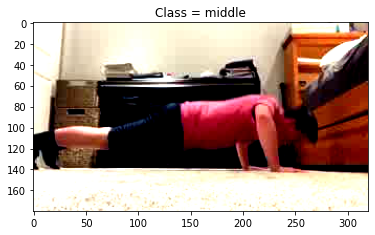

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


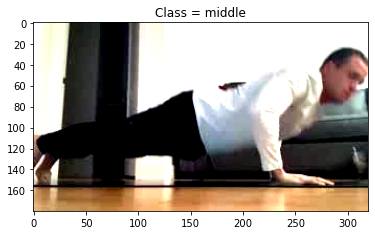

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


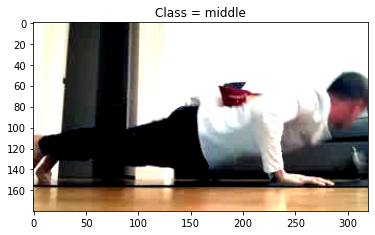

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


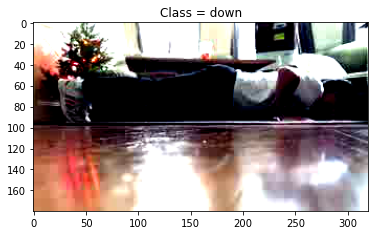

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


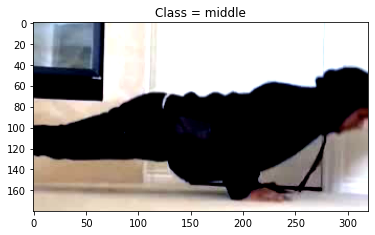

In [139]:
for i, data in enumerate(valloader):
    images, labels = data
    for i in range(5):
        show_sample(images[i], labels[i])
    break

In [140]:
for param in vgg16.parameters():
    param.requires_grad = True

In [141]:
train(vgg16, epochs=10, path='vgg16.pth')

Epoch 0/9
----------
train Loss: 0.5127 Acc: 80.2403
val Loss: 0.3217 Acc: 92.0213
Epoch 1/9
----------
train Loss: 0.3794 Acc: 85.0467
val Loss: 0.2426 Acc: 95.7447
Epoch 2/9
----------
train Loss: 0.2858 Acc: 89.3191
val Loss: 0.1950 Acc: 95.7447
Epoch 3/9
----------
train Loss: 0.2717 Acc: 89.8531
val Loss: 0.1736 Acc: 94.1489
Epoch 4/9
----------
train Loss: 0.2246 Acc: 90.6542
val Loss: 0.1509 Acc: 93.0851
Epoch 5/9
----------
train Loss: 0.1829 Acc: 92.5234
val Loss: 0.1700 Acc: 92.0213
Epoch 6/9
----------
train Loss: 0.1842 Acc: 91.5888
val Loss: 0.1235 Acc: 96.8085
Epoch 7/9
----------
train Loss: 0.1594 Acc: 94.1255
val Loss: 0.1477 Acc: 95.2128
Epoch 8/9
----------
train Loss: 0.1127 Acc: 96.7957
val Loss: 0.1226 Acc: 94.6809
Epoch 9/9
----------
train Loss: 0.1291 Acc: 94.5260
val Loss: 0.1361 Acc: 94.6809
Training complete in 2m 51s
Best val Acc: 96.808511


We see that we achieve a Validation accuracry of around 97% after 10 epochs! Not bad!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


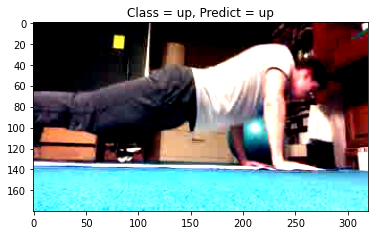

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


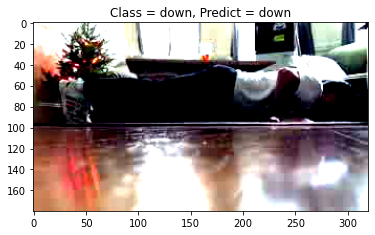

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


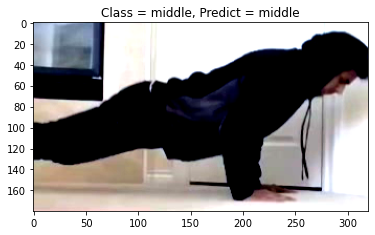

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


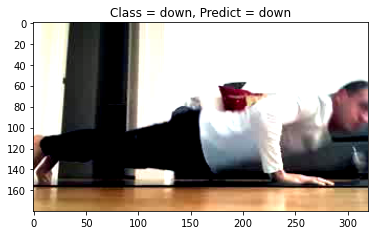

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


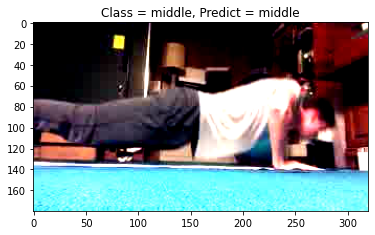

In [143]:
with torch.no_grad():           # Do not update gradients when evaluating
    for i, data in enumerate(valloader):
        images, labels = data[0].to(device), data[1].to(device)
        vgg16.eval() 
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        for i in range(5):
            show_sample(images[i], labels[i], predicted[i])
        break

Now that we have the model trained, lets test it on some real videos! Since I encountered some weird issues with some videos being rortated, I added in some code I found (second link in the bibliograhy) that was supposed to fix it. However, the mov's didnt have the correct tag, so it didn't work, for now, I'll just limit my test videos to ones that are rotated correctly

In [62]:
import sys
import cv2 as cv
import ffmpeg

In [63]:
def check_rotation(path_video_file):
    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)
    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotateCode = None
    if int(meta_dict['streams'][0]['tags'].get('rotate')) == 90:
        rotateCode = cv2.ROTATE_90_CLOCKWISE
    elif int(meta_dict['streams'][0]['tags'].get('rotate')) == 180:
        rotateCode = cv2.ROTATE_180
    elif int(meta_dict['streams'][0]['tags'].get('rotate')) == 270:
        rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE

    return rotateCode

def correct_rotation(frame, rotateCode):  
    return cv.rotate(frame, rotateCode) 

Here we use open CV to take a video and turn it into a list of images. We can then use the images to count the pushups!

In [83]:
def get_images(pathIn):
    images = []
    count = 0
    vidcap = cv.VideoCapture(pathIn)
    # rotateCode = check_rotation(pathIn) Currently not using
    success, image = vidcap.read()
    while success:
        vidcap.set(cv.CAP_PROP_POS_MSEC,(count*200))
        # cv2.imwrite(pathOut + f'frame-{count}.jpg', image)     # save frame as JPEG file
#         if rotateCode is not None:
#             image = correct_rotation(image, rotateCode)
        # plt.imshow(image)
        images.append(image)
        count = count + 1
        success,image = vidcap.read()
    print('Finished Extraction')
    return images

In [147]:
path_to_movie = './nick.mov'
images = get_images(path_to_movie)

Finished Extraction


In [148]:
from PIL import Image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((180, 320)),  
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def image_loader(image):
    """load image, returns cuda tensor"""
    image = transform(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

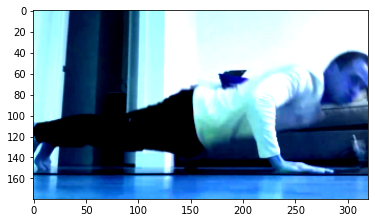

In [149]:
for i in range(10):
    img = image_loader(images[i]) / 2 + 0.5    
    npimg = img.to('cpu').numpy() # convert back to numpy for plt
    plt.imshow(np.transpose(npimg[0], (1, 2, 0)))

In [150]:
last = 0
status = {
    0: 'start',
    1: 'going down',
    2: 'down',
    3: 'going up'
}

failed = 0
total = 0

with torch.no_grad(): 
    vgg16.eval()
    for image in images:
        image = image_loader(image) 

        output = vgg16(image)

        _, predicted = torch.max(output.data, 1) # Get the arg max
        state = int(predicted[0])
        #show_sample(image[0], state)
        if state == UP:
            if last == 1:
                failed += 1
            if last == 2 or last == 3:
                total += 1
            last = 0
        elif state == MIDDLE:
            if last == 0:
                last = 1
            if last == 2:
                last = 3
        else:
            last = 2
        #print(status[last])
    print(f'Total pushups done: {total}, failed pushups: {failed}')


Total pushups done: 29, failed pushups: 0


Wow! So it looks like our counter is almost perfect! There were 30 pushups in the video. The only one it didn't count was the last one, since the last image it took was a bit too low. So maybe we should leave a bit more buffer time before I cut the video. This first video we used was part of the training. Let's try to use some videos that are not part of the training. 

In [90]:
resnext50 = models.resnext50_32x4d(pretrained=True).to(device)

In [95]:
for param in resnext50.parameters():
    param.requires_grad = False
resnext50.fc = nn.Linear(2048, 3)

In [96]:
train(resnext50, epochs=10, path='resnext50.pth')

[1,    20] Validation Loss: 1.111
Saving model
[1,    40] Validation Loss: 1.106
Saving model
Accuracy at end of epoch 0: 39.894
[2,    20] Validation Loss: 1.446
[2,    40] Validation Loss: 1.063
Saving model
Accuracy at end of epoch 1: 49.468
[3,    20] Validation Loss: 1.388
[3,    40] Validation Loss: 1.026
Saving model
Accuracy at end of epoch 2: 61.702
[4,    20] Validation Loss: 1.346
[4,    40] Validation Loss: 0.966
Saving model
Accuracy at end of epoch 3: 66.489
[5,    20] Validation Loss: 1.294
[5,    40] Validation Loss: 0.954
Saving model
Accuracy at end of epoch 4: 69.681
[6,    20] Validation Loss: 1.258
[6,    40] Validation Loss: 0.919
Saving model
Accuracy at end of epoch 5: 69.681
[7,    20] Validation Loss: 1.218
[7,    40] Validation Loss: 0.890
Saving model
Accuracy at end of epoch 6: 72.872
[8,    20] Validation Loss: 1.181
[8,    40] Validation Loss: 0.867
Saving model
Accuracy at end of epoch 7: 70.213
[9,    20] Validation Loss: 1.161
[9,    40] Validation Los

Hmm, 76% is worse than vgg16, maybe it will keep improving if we give it more time, lets try 10 more epochs.

In [97]:
train(resnext50, epochs=10, path='resnext50.pth')

[1,    20] Validation Loss: 0.805
Saving model
[1,    40] Validation Loss: 0.826
Accuracy at end of epoch 0: 77.660
[2,    20] Validation Loss: 1.084
[2,    40] Validation Loss: 0.791
Saving model
Accuracy at end of epoch 1: 77.128
[3,    40] Validation Loss: 0.755
Saving model
Accuracy at end of epoch 2: 80.851
[4,    20] Validation Loss: 1.043
[4,    40] Validation Loss: 0.757
Accuracy at end of epoch 3: 80.851
[5,    20] Validation Loss: 1.021
[5,    40] Validation Loss: 0.747
Saving model
Accuracy at end of epoch 4: 78.191
[6,    20] Validation Loss: 1.020
[6,    40] Validation Loss: 0.721
Saving model
Accuracy at end of epoch 5: 80.319
[7,    20] Validation Loss: 0.961
[7,    40] Validation Loss: 0.716
Saving model
Accuracy at end of epoch 6: 85.638
[8,    20] Validation Loss: 0.973
[8,    40] Validation Loss: 0.704
Saving model
Accuracy at end of epoch 7: 87.766
[9,    20] Validation Loss: 0.953
[9,    40] Validation Loss: 0.701
Saving model
Accuracy at end of epoch 8: 78.723
[10

87% is better, but maybe we should try resnet instead of resnext

In [98]:
resnet50 = models.resnet50(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [99]:
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Linear(2048, 3)

I'll let this train for 20 epochs as well

In [101]:
train(resnet50, epochs=10, path='resnet50.pth')

[1,    20] Validation Loss: 0.824
Saving model
[1,    40] Validation Loss: 0.824
Accuracy at end of epoch 0: 73.936
[2,    20] Validation Loss: 1.107
[2,    40] Validation Loss: 0.806
Saving model
Accuracy at end of epoch 1: 71.277
[3,    20] Validation Loss: 1.095
[3,    40] Validation Loss: 0.784
Saving model
Accuracy at end of epoch 2: 75.532
[4,    20] Validation Loss: 1.049
[4,    40] Validation Loss: 0.791
Accuracy at end of epoch 3: 79.787
[5,    20] Validation Loss: 1.034
[5,    40] Validation Loss: 0.774
Saving model
Accuracy at end of epoch 4: 74.468
[6,    20] Validation Loss: 1.048
[6,    40] Validation Loss: 0.748
Saving model
Accuracy at end of epoch 5: 79.787
[7,    20] Validation Loss: 0.995
[7,    40] Validation Loss: 0.742
Saving model
Accuracy at end of epoch 6: 79.787
[8,    20] Validation Loss: 0.996
[8,    40] Validation Loss: 0.732
Saving model
Accuracy at end of epoch 7: 80.319
[9,    20] Validation Loss: 0.975
[9,    40] Validation Loss: 0.712
Saving model
Accu

It seems that I'm not seeing as good of results from resnet as I did from resnext, or vgg16. Lets see what happens after I unfreeze resnext.

In [102]:
for param in resnext50.parameters():
    param.requires_grad = True

In [104]:
train(resnext50, epochs=5, path='resnext50.pth')

[1,    20] Validation Loss: 0.223
Saving model
[1,    40] Validation Loss: 0.181
Saving model
Accuracy at end of epoch 0: 93.085
[2,    20] Validation Loss: 0.300
[2,    40] Validation Loss: 0.249
Accuracy at end of epoch 1: 93.617
[3,    20] Validation Loss: 0.284
[3,    40] Validation Loss: 0.207
Accuracy at end of epoch 2: 94.149
[4,    20] Validation Loss: 0.256
[4,    40] Validation Loss: 0.202
Accuracy at end of epoch 3: 93.617
[5,    20] Validation Loss: 0.280
[5,    40] Validation Loss: 0.213
Accuracy at end of epoch 4: 92.021


After 20 epochs, it seems to be getting pretty high up, around 94%, however, its not the 96% we saw with vgg16. However, I noticed the accuracy started decreasing towards the end, so it seems to be overfitting.

Let's try resnet152, if its not better than vgg16 then we will stay with vgg16

In [109]:
resnet152 = models.resnet152(pretrained=True).to(device)

In [110]:
for param in resnet152.parameters():
    param.requires_grad = False
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 3)

In [111]:
train(resnet152, epochs=15, path='resnet152.pth')

[1,    20] Validation Loss: 1.102
Saving model
[1,    40] Validation Loss: 1.080
Saving model
Accuracy at end of epoch 0: 39.362
[2,    20] Validation Loss: 1.442
[2,    40] Validation Loss: 1.038
Saving model
Accuracy at end of epoch 1: 51.596
[3,    20] Validation Loss: 1.378
[3,    40] Validation Loss: 1.013
Saving model
Accuracy at end of epoch 2: 56.915
[4,    20] Validation Loss: 1.325
[4,    40] Validation Loss: 0.957
Saving model
Accuracy at end of epoch 3: 60.638
[5,    20] Validation Loss: 1.295
[5,    40] Validation Loss: 0.942
Saving model
Accuracy at end of epoch 4: 72.872
[6,    20] Validation Loss: 1.237
[6,    40] Validation Loss: 0.907
Saving model
Accuracy at end of epoch 5: 67.553
[7,    20] Validation Loss: 1.220
[7,    40] Validation Loss: 0.889
Saving model
Accuracy at end of epoch 6: 77.128
[8,    20] Validation Loss: 1.184
[8,    40] Validation Loss: 0.866
Saving model
Accuracy at end of epoch 7: 65.957
[9,    20] Validation Loss: 1.170
[9,    40] Validation Los

In [112]:
for param in resnet152.parameters():
    param.requires_grad = True

In [113]:
train(resnet152, epochs=15, path='resnet152.pth')

[1,    20] Validation Loss: 0.714
Saving model
[1,    40] Validation Loss: 0.662
Saving model
Accuracy at end of epoch 0: 82.447
[2,    20] Validation Loss: 0.812
[2,    40] Validation Loss: 0.519
Saving model
Accuracy at end of epoch 1: 89.362
[3,    20] Validation Loss: 0.678
[3,    40] Validation Loss: 0.447
Saving model
Accuracy at end of epoch 2: 90.957
[4,    20] Validation Loss: 0.575
[4,    40] Validation Loss: 0.385
Saving model
Accuracy at end of epoch 3: 92.553
[5,    20] Validation Loss: 0.494
[5,    40] Validation Loss: 0.378
Saving model
Accuracy at end of epoch 4: 94.149
[6,    20] Validation Loss: 0.420
[6,    40] Validation Loss: 0.319
Saving model
Accuracy at end of epoch 5: 93.617
[7,    20] Validation Loss: 0.394
[7,    40] Validation Loss: 0.308
Saving model
Accuracy at end of epoch 6: 92.553
[8,    20] Validation Loss: 0.381
[8,    40] Validation Loss: 0.247
Saving model
Accuracy at end of epoch 7: 92.021
[9,    20] Validation Loss: 0.356
[9,    40] Validation Los

Wow, it looks like this worked great! Lets try to unfreeze to see what we can get to! I may have included the wrong in_features for the first res net I made, so maybe thats why it didn't train as well.

Bibliography: <br>
Documentation on training different networks https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html